# Exploring the summary data of flights from Brazil

## 1. Introduction

One of the industries that was very impacted by the COVID-19 pandemic was the air transport industry. The data shared by ANAC - the Brazilian Civil Aviation Authority - presents how it was affected. Let's explore this data in this Jupyter notebook and see if we can answer some questions and get some insights.

The data used in this notebook may be found at:

- https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/dados-estatisticos/arquivos/resumo_anual_2019.csv
- https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/dados-estatisticos/arquivos/resumo_anual_2020.csv
- https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/dados-estatisticos/arquivos/resumo_anual_2021.csv

## 2. Importing the libraries and data clean-up

First of all, let's import the libraries we are going to use:

In [25]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import unidecode

I am using the Seaborn library instead of matplotlib. I am also using the unidecode library to convert the column names to a more friendly format.

Now the files are loaded and merged into a single dataframe.

In [26]:
folder = r'C:\Users\thiag\data\ANAC-transport'

dffiles = ['resumo_anual_2019.csv',
         'resumo_anual_2020.csv',
         'resumo_anual_2021.csv']

df = pd.concat([pd.read_csv(os.path.join(folder, x),
                            sep=';', encoding=('ISO-8859-1'))
                for x in dffiles])

Let's look at the data.

In [27]:
print(df.head())

  EMPRESA (SIGLA) EMPRESA (NOME) EMPRESA (NACIONALIDADE)   ANO  MÊS  \
0             AAF     AIGLE AZUR             ESTRANGEIRA  2019    1   
1             AAF     AIGLE AZUR             ESTRANGEIRA  2019    1   
2             AAF     AIGLE AZUR             ESTRANGEIRA  2019    2   
3             AAF     AIGLE AZUR             ESTRANGEIRA  2019    2   
4             AAF     AIGLE AZUR             ESTRANGEIRA  2019    3   

  AEROPORTO DE ORIGEM (SIGLA) AEROPORTO DE ORIGEM (NOME)  \
0                        LFPO          ORLY (NEAR PARIS)   
1                        SBKP                   CAMPINAS   
2                        LFPO          ORLY (NEAR PARIS)   
3                        SBKP                   CAMPINAS   
4                        LFPO          ORLY (NEAR PARIS)   

  AEROPORTO DE ORIGEM (UF) AEROPORTO DE ORIGEM (REGIÃO)  \
0                      NaN                          NaN   
1                       SP                      SUDESTE   
2                      NaN         

The following can be observed about the column names:
- They are written in Portuguese and contain accentuation;
- They are all in upper case letters;
- They contain spaces and parenthesis.

To facilitate readability we will modify the column names by:
- Replacing the spaces with underlines "_";
- Removing the parenthesis;
- Making all letters lowercase; and
- Removing the accents.
This convention is called snake_case and, even though not standard, it is frequently used. For more information, refer to: https://en.wikipedia.org/wiki/Snake_case

In [28]:
print("Column names before changes:\n")
print(df.columns)

df.columns = [unidecode.unidecode(z.lower())
              .replace(' ','_')
              .replace('(','')
              .replace(')','') 
              for z in df.columns]

df.to_csv('3years.csv', sep=';', index=False)

print("Column names after changes:\n")

print(df.columns)

Column names before changes:

Index(['EMPRESA (SIGLA)', 'EMPRESA (NOME)', 'EMPRESA (NACIONALIDADE)', 'ANO',
       'MÊS', 'AEROPORTO DE ORIGEM (SIGLA)', 'AEROPORTO DE ORIGEM (NOME)',
       'AEROPORTO DE ORIGEM (UF)', 'AEROPORTO DE ORIGEM (REGIÃO)',
       'AEROPORTO DE ORIGEM (PAÍS)', 'AEROPORTO DE ORIGEM (CONTINENTE)',
       'AEROPORTO DE DESTINO (SIGLA)', 'AEROPORTO DE DESTINO (NOME)',
       'AEROPORTO DE DESTINO (UF)', 'AEROPORTO DE DESTINO (REGIÃO)',
       'AEROPORTO DE DESTINO (PAÍS)', 'AEROPORTO DE DESTINO (CONTINENTE)',
       'NATUREZA', 'GRUPO DE VOO', 'PASSAGEIROS PAGOS', 'PASSAGEIROS GRÁTIS',
       'CARGA PAGA (KG)', 'CARGA GRÁTIS (KG)', 'CORREIO (KG)', 'ASK', 'RPK',
       'ATK', 'RTK', 'COMBUSTÍVEL (LITROS)', 'DISTÂNCIA VOADA (KM)',
       'DECOLAGENS', 'CARGA PAGA KM', 'CARGA GRATIS KM', 'CORREIO KM',
       'ASSENTOS', 'PAYLOAD', 'HORAS VOADAS', 'BAGAGEM (KG)'],
      dtype='object')
Column names after changes:

Index(['empresa_sigla', 'empresa_nome', 'empresa_nacio

This looks better.
Let's add some new columns to this dataframe, to support our analysis:
- Since we are looking for a cronologic observation, it is insteresting to concatenate the calendar months and years into a single variable called 'data' (Portuguese for date. I am keeping Portuguese names for consistency). Let's also add a column named 'quarto' (Portuguese for quarter) to concatenate variables around the months of the year 3-by-3.
- We can also infer the routes from the origin and destination airport variables (respectivelly called aeroporto_de_origem_sigla and aeroporto_de_destino_sigla). A variable named 'rota' (Portuguese for route) will be created to store the 'origin->destination' string. Another variable with the names of the airports (instead of the codes) will be created (and alled 'rota_nome') for readability (not everyone knows all airport codes).
- Dividing RPK for ASK we get the load factor, which is a very important metric for airlines economics. This variable will also be created.


In [29]:
df['data'] = [str(x['ano']) + '-' + "{:02}".format(x['mes'])
              for index, x in df.iterrows()]

df['rota'] = [str(x['aeroporto_de_origem_sigla']) + '->' +
              str(x['aeroporto_de_destino_sigla'])
              for index, x in df.iterrows()]

df['rota_nome'] = [str(x['aeroporto_de_origem_nome']) + '->' +
              str(x['aeroporto_de_destino_nome'])
              for index, x in df.iterrows()]

df['load_factor'] = df['rpk']/df['ask']

def quarter(x):
    year = x['ano']
    mes = x['mes']
    if mes in [1, 2, 3]:
        quarter = str(year) + '-Q1' 
    elif mes in [4, 5, 6]:
        quarter = str(year) + '-Q2' 
    elif mes in [7, 8, 9]:
        quarter = str(year) + '-Q3' 
    elif mes in [10, 11, 12]:
        quarter = str(year) + '-Q4' 
    return quarter

df['quarter'] = df.apply(quarter, axis=1)

## 3. Airline metrics for efficiency and capacity

Since there is no data dictionary, it is now a good time to talk about some interesting variables:
- RPK meaning "Revenue Passenger Kilometers" is an air transport industry metric that aggregates the number of paying passengers and the quantity of kilometers traveled by them. It is calculated by multiplying the number of paying passengers by the distance traveled in kilometers.
- ASK meaning "Available Seat Kilometers" is similar to the RPK but instead of using the paying passengers, the passenger capacity (number of seats available in the aircraft) is multiplied by the traveled distance.
- RTK (for "Revenue tonne kilometres") measures the revenue cargo load in tonnes multiplied by the distance flown in kilometers.
- ATK (for "Available tonne kilometres") measures the aircraft capacity of cargo load in tonnes multiplied by the distance flown in kilometers.

The dataframe presents not only the value of these parameters but also the variables that compose their formula. Therefore, let's make a consistency check, verifying it is possible to reproduce their values through the variables.

The formulas of the variables are:

$ RPK = \frac{\sum{PayingPassengers} \ \times \ distance}{\sum{flights}} $

$ ASK = \frac{\sum{Seats} \ \times \ distance}{\sum{flights}} $

$ RTK = \frac{(AvgWeight \ \times \ \sum{PayingPassengers \ + \ BaggageWeight \ + \ CargoWeight \ + \ MailWeight)  } \ \times \ distance}{1000 \ \times \ \sum{flights}} $

$ ASK = \frac{\sum{Payload} \ \times \ distance}{1000 \ \times \ \sum{flights}} $

In [6]:
dummy = []
for index, x in df.iterrows():
    if x['decolagens'] == 0:
        dummy.append(abs(x['rpk']) < 1000)
    else:
        dummy.append(abs(x['rpk'] - x['passageiros_pagos']*x['distancia_voada_km']/x['decolagens']) < 1000)
print('The number of rpk values that correspond to rpk calculation is: {:.2f}%'.format(100*sum(dummy)/len(dummy)))
df['rpk_calc']= df['passageiros_pagos']*df['distancia_voada_km']/df['decolagens']
del dummy


dummy = []
for index, x in df.iterrows():
    if x['decolagens'] == 0:
        dummy.append(abs(x['ask']) < 1000)
    else:
        dummy.append(abs(x['ask'] - x['assentos']*x['distancia_voada_km']/x['decolagens']) < 1000)
print('The number of ask values that correspond to ask calculation is: {:.2f}%'.format(100*sum(dummy)/len(dummy)))
df['ask_calc']=df['assentos']*df['distancia_voada_km']/df['decolagens']

del dummy

dummy = []
for index, x in df.iterrows():
    if x['decolagens'] == 0:
        dummy.append(abs(x['rtk']) < 1000)
    else:
        dummy.append(abs(x['rtk'] - (75*x['passageiros_pagos']+x['carga_paga_kg']+x['correio_kg']+x['bagagem_kg'] )*
                         x['distancia_voada_km']/(1000*x['decolagens'])) < 1000)
print('The number of rtk values that correspond to rtk calculation is: {:.2f}%'.format(100*sum(dummy)/len(dummy)))
df['rtk_calc']=(75*df['passageiros_pagos']+df['carga_paga_kg']+df['correio_kg']+df['bagagem_kg']
                )*df['distancia_voada_km']/(1000*df['decolagens'])

del dummy

dummy = []
for index, x in df.iterrows():
    if x['decolagens'] == 0:
        dummy.append(abs(x['atk']) < 1000)
    else:
        dummy.append(abs(x['atk'] - x['payload']*x['distancia_voada_km']/(1000*x['decolagens'])) < 1000)
print('The number of atk values that correspond to atk calculation is: {:.2f}%'.format(100*sum(dummy)/len(dummy)))
df['atk_calc']=df['payload']*df['distancia_voada_km']/(1000*df['decolagens'])

del dummy

The number of rpk values that correspond to rpk calculation is: 70.51%
The number of ask values that correspond to ask calculation is: 86.68%
The number of rtk values that correspond to rtk calculation is: 56.28%
The number of atk values that correspond to atk calculation is: 86.13%


We can see that the consistency is variable, and is specifically lower for RTK values.

One clear disadvantage of the calculated RTK is that the same average weight (75 kg) was used for all passengers of all airlines. This assumption implies that Brazilian and foreign companies use (or have to use) the same value for passenger weight to do their flight planning, which may not be true.

Let's observe if being a Brazilian airline or foreign airline has an effect in the relationship between reported RTK and calculated RTK:



<AxesSubplot:xlabel='rtk', ylabel='rtk_calc'>

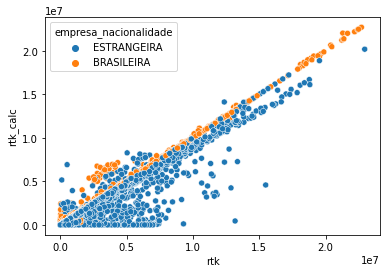

In [7]:
sns.scatterplot(x=df['rtk'],y=df['rtk_calc'],hue=df['empresa_nacionalidade'])

We can see clearly that the line y=x has many Brazilian airlines into it, but not foreign. Also, there is a second line below the y=x line, suggesting a different tendency for some foreign airlines.

By optimizing the error between RKT and calculated RTK for Brazilian airlines and foreign airlines separately, we arrive at the following values:
- Brazilian airlines have 75kg as the best average value for passenger weight;
- Foreign airlines have 90kg as the best average value for passenger weight.

These numbers come from an optimization exercise is found in the article below:

## PUT LINK HERE

With this knowledge, let's calculate again the RTK:

In [8]:
dummy = []
rtk_calc = []
for index, x in df.iterrows():
    if x['empresa_nacionalidade'] == 'BRASILEIRA':
        avgw = 75
    elif x['empresa_nacionalidade'] == 'ESTRANGEIRA':
        avgw = 90
        
    if x['decolagens'] == 0:
        rtk = float('NaN')
        dummy.append(abs(x['rtk']) < 1000)
    else:
        rtk = (avgw*x['passageiros_pagos']+x['carga_paga_kg']+x['correio_kg']+x['bagagem_kg']
           )*x['distancia_voada_km']/(1000*x['decolagens'])
        dummy.append(abs(x['rtk'] - rtk) < 1000)
    rtk_calc.append(rtk)

print('The number of rtk values that correspond to rtk calculation is: {:.2f}%'.format(100*sum(dummy)/len(dummy)))
df['rtk_calc'] = rtk_calc

del dummy, rtk_calc, rtk

The number of rtk values that correspond to rtk calculation is: 58.90%


We see now that the match of RTK values passed from 56.28% to 58.93%. Let's also reprint the previous graphic with the corrected calculated RTK.

<AxesSubplot:xlabel='rtk', ylabel='rtk_calc'>

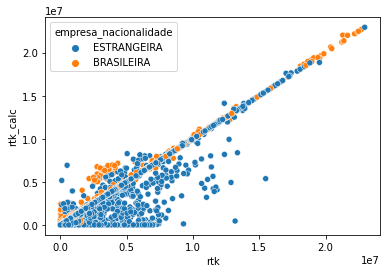

In [9]:
sns.scatterplot(x=df['rtk'],y=df['rtk_calc'],hue=df['empresa_nacionalidade'])

We can see that the second tendency line is gone, since we have took into consideration its behaviour in our model.

## 4. Evolution of number of flights

After the consistency check, let's take a look on how the number of flights has evolved through time in our database flights.

Text(0.5, 0.98, '# Flights per month')

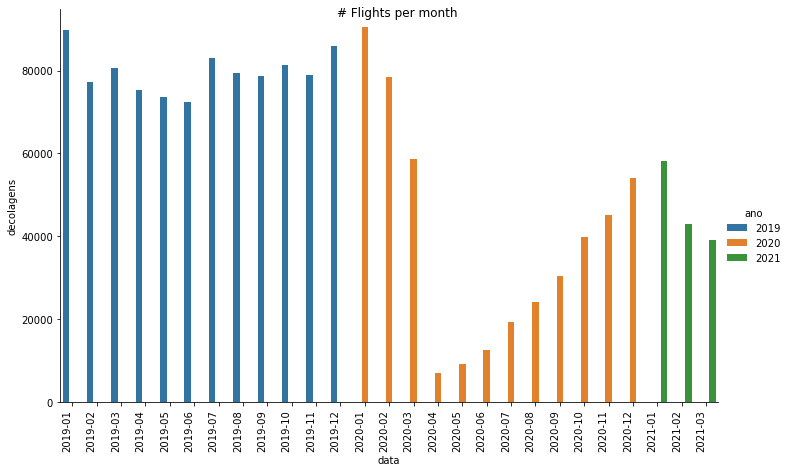

In [10]:
df1 = pd.DataFrame(df.groupby(by=['data','ano']).agg('sum')['decolagens'])

df1.reset_index(inplace=True)
ax = sns.catplot(x='data', y='decolagens', data=df1, kind='bar', hue='ano', height=6, aspect=10/6,
                 sharey=True)

ax.set_xticklabels(rotation=90, ha="right")    
ax.fig.suptitle('# Flights per month')

We can see the number of flights diminishes drastically after March 2020. Interestingly enough, this should not be credited only to the pandemic effect, since January is the month with most flights in an year.

Let's verify what are the busiest airports (according to number of takeoffs) in Brazil, according to ANAC's data:

                          decolagens
aeroporto_de_origem_nome            
GUARULHOS                   233420.0
RIO DE JANEIRO              139209.0
SÃO PAULO                   124867.0
CAMPINAS                    103436.0
BRASÍLIA                    101135.0
CONFINS                      80310.0
RECIFE                       63420.0
PORTO ALEGRE                 52173.0
SALVADOR                     50196.0
SÃO JOSÉ DOS PINHAIS         45537.0


Text(0.5, 0.98, '# Flights per airport')

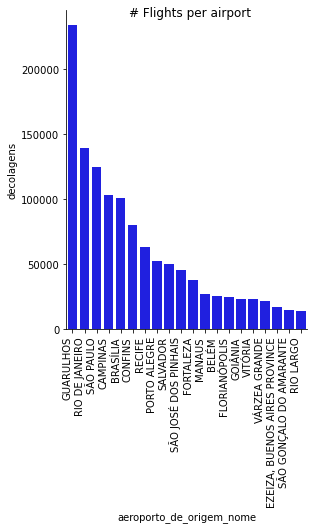

In [11]:
df2 = pd.DataFrame(df.groupby(by=['aeroporto_de_origem_nome']).agg('sum')['decolagens'])
df2 = df2.sort_values(by=['decolagens'], ascending=False)
print(df2[:10])
df2.reset_index(inplace=True)

ax = sns.catplot(x='aeroporto_de_origem_nome', y='decolagens',
                 data=df2[:20], kind='bar', color='b', sharey=True)

ax.set_xticklabels(rotation=90, ha="right")
ax.fig.suptitle('# Flights per airport')

Finally, let's verify which airports have been most affected by the travel restrictions.

"Most affected" here is defined by the difference between the quantity of flights in the first quarter of 2020, when the COVID-19 was discovered and started imposing restrictions and the first quarter of 2019. With that we account for the sazonality of the air traffic. We make this calculation for each airport, absolute (in difference of flight quantities) and in percentage. 

Absolute numbers are important to observe since an airport that had 1 flight in 2019 and had 0 in 2020 has lost 100% of its flights, but has lost only one flight. We'd like to avoid accounting cases like this as the most impactful, since they shouldn't be.

In [24]:
df3 = pd.DataFrame(df.groupby(by=['quarter',
                                  'aeroporto_de_origem_nome']).agg('sum')[
                                      'decolagens'])
df3.reset_index(inplace=True)

df3 = df3.pivot(index='aeroporto_de_origem_nome',columns=['quarter'],values='decolagens').fillna(0)
df3['delta2020'] = df3['2019-Q2']-df3['2020-Q2']
df3['delta_perc2020'] = 100*df3['delta2020']/df3['2019-Q2']
df3['delta_perc2021'] = 100*(df3['2019-Q1']-df3['2021-Q1'])/df3['2019-Q1']

df3 = df3.sort_values(by='delta2020',ascending=False)

print(df3[: 10])

quarter                   2019-Q1  2019-Q2  2019-Q3  2019-Q4  2020-Q1  \
aeroporto_de_origem_nome                                                
GUARULHOS                 35860.0  31179.0  35204.0  36139.0  33677.0   
SÃO PAULO                 21869.0  20541.0  21562.0  22668.0  19916.0   
RIO DE JANEIRO            23031.0  19658.0  22195.0  24090.0  22097.0   
BRASÍLIA                  15672.0  14208.0  15204.0  15889.0  14281.0   
CONFINS                   12448.0  12108.0  12994.0  12646.0  11160.0   
CAMPINAS                  13954.0  14029.0  14262.0  13603.0  12132.0   
RECIFE                     9177.0   8359.0   9012.0   9040.0   8623.0   
PORTO ALEGRE               8198.0   7702.0   8538.0   8756.0   7970.0   
SÃO JOSÉ DOS PINHAIS       7435.0   7173.0   7757.0   7942.0   6816.0   
SALVADOR                   8117.0   5821.0   7298.0   7740.0   7434.0   

quarter                   2020-Q2  2020-Q3  2020-Q4  2021-Q1  delta2020  \
aeroporto_de_origem_nome                        

We can see that the list of most impacted airports (refer to variable 'delta_perc2020') is identical to the list of most busy airports (except for the order).

We can also see, by comparing the first quarter of 2021 with the first quarter of 2019 that the gap is closing for all airports, and airports like Campinas and Recife have currently only 14% less flights than they had two years ago - which is very good news for the aviation in Brazil.

As of now, the COVID-19 vaccination is progressing and ICAO and the airlines are make decisions to improve the safety of air travel while containing the spread of diseases. Therefore, measures are being taken to allow these air travel numbers to return to 2019 as fast as possible. I look forward to see the airports busy again! 